# Semiconductor Bloch Equations (SBEs) Solver

:::{abstract}
This tutorial covers the `SBEs` module, which solves the 1D Semiconductor Bloch Equations for quantum wire systems. We demonstrate initialization, time evolution, many-body effects, and integration with Maxwell field propagation. The SBEs describe the quantum mechanical dynamics of electrons and holes in semiconductors under optical excitation.
:::

:::{warning}
**This is the most important documentation file in the entire PSTD3D package.**

The `SBEs` module is the **central unifying component** that integrates all PSTD3D submodules into a cohesive simulation framework. Understanding SBEs is essential for understanding how the entire system works together.

**SBEs unifies the following modules:**
- **qwoptics**: Field projection between propagation and quantum wire spaces, polarization and charge density calculations
- **coulomb**: Screened Coulomb interactions, excitonic correlations, many-body effects
- **dephasing**: Momentum-dependent dephasing rates, carrier-carrier and carrier-phonon scattering
- **phonons**: Phonon scattering rates, temperature-dependent effects
- **emission**: Spontaneous recombination, photoluminescence
- **dcfield**: DC transport, drift and diffusion effects

The `InitializeSBE` function orchestrates initialization of all these subsystems, and `QWCalculator` coordinates their operation during time evolution. This documentation shows how all these pieces work together to solve the complete many-body semiconductor problem.
:::

## Theory

The Semiconductor Bloch Equations (SBEs) are a set of coupled differential equations that describe the time evolution of quantum coherence in semiconductor systems. They extend the optical Bloch equations to include many-body Coulomb interactions, carrier-carrier scattering, and phonon effects.

### The Three Coupled Equations

The SBEs consist of three coupled equations for three coherence matrices:

**1. Electron-Hole Coherence (Interband Polarization):**

$$
i\hbar \frac{dp_{k_e,k_h}}{dt} = \sum_{k'} H_{k_h,k'}^{hh} p_{k',k_e} + \sum_{k'} H_{k_e,k'}^{ee} p_{k_h,k'} - \sum_{k'} H_{k',k_h}^{eh\dagger} C_{k',k_e} - \sum_{k'} H_{k_e,k'}^{eh} D_{k',k_h} + H_{k_e,k_h}^{eh} - i\hbar(\gamma_e(k_e) + \gamma_h(k_h)) p_{k_e,k_h} + \Gamma_p^{off}(k_e,k_h)
$$

where $p_{k_e,k_h}$ is the electron-hole coherence matrix representing interband polarization.

**2. Electron-Electron Coherence:**

$$
i\hbar \frac{dC_{k_1,k_2}}{dt} = \sum_{k'} H_{k_2,k'}^{ee} C_{k_1,k'} - \sum_{k'} H_{k',k_1}^{ee} C_{k',k_2} + \sum_{k'} H_{k_2,k'}^{eh} p_{k_1,k'}^\dagger - \sum_{k'} H_{k',k_1}^{eh\dagger} p_{k',k_2}
$$

where $C_{k_1,k_2}$ is the electron-electron coherence matrix. Diagonal elements $C_{k,k} = n_e(k)$ are electron occupation numbers.

**3. Hole-Hole Coherence:**

$$
i\hbar \frac{dD_{k_1,k_2}}{dt} = \sum_{k'} H_{k_2,k'}^{hh} D_{k_1,k'} - \sum_{k'} H_{k',k_1}^{hh} D_{k',k_2} + \sum_{k'} H_{k',k_2}^{eh\dagger} p_{k',k_1}^\dagger - \sum_{k'} H_{k_1,k'}^{eh\dagger} p_{k_2,k'}
$$

where $D_{k_1,k_2}$ is the hole-hole coherence matrix. Diagonal elements $D_{k,k} = n_h(k)$ are hole occupation numbers.

### Hamiltonian Construction

The effective Hamiltonians include:

**Electron-Hole Hamiltonian:**

$$
H_{k_e,k_h}^{eh} = M_{k_e,k_h}^{eh} + \sum_q V_{eh}(q) p_{k_e+q,k_h+q}^\dagger
$$

where $M^{eh}$ is the dipole-field coupling and $V_{eh}$ is the screened Coulomb interaction.

**Electron-Electron Hamiltonian:**

$$
H_{k_1,k_2}^{ee} = E_e(k_1)\delta_{k_1,k_2} - \sum_q V_{ee}(q) C_{k_1+q,k_2+q}^\dagger + \sum_k [V_{ee}(q)C_{k,k+q} - V_{eh}(q)D_{k+q,k}]
$$

**Hole-Hole Hamiltonian:**

$$
H_{k_1,k_2}^{hh} = E_h(k_1)\delta_{k_1,k_2} - \sum_q V_{hh}(q) D_{k_1+q,k_2+q}^\dagger + \sum_k [V_{hh}(q)D_{k,k+q} - V_{eh}(q)C_{k+q,k}]
$$

### Time Evolution Scheme

The SBEs use a leapfrog integration scheme with reshuffling for stability:

1. **Leapfrog step:** $X_3 = X_1 + \frac{dX}{dt} \cdot 2\Delta t$ (2nd order accurate)
2. **Reshuffling:** $X_2 = \frac{X_1 + X_3}{2}$ (converts to stable 1st order scheme)

where $X$ represents any of the coherence matrices (p, C, D).

### Many-Body Effects

The SBEs include:

- **Coulomb interactions:** Screened electron-electron, hole-hole, and electron-hole interactions
- **Excitonic correlations:** Bound electron-hole pairs (excitons)
- **Carrier-carrier scattering:** Many-body collision terms (MBCE, MBCH)
- **Phonon scattering:** Carrier-phonon interactions (MBPE, MBPH)
- **Dephasing:** Momentum-dependent dephasing rates $\gamma_e(k)$, $\gamma_h(k)$
- **DC transport:** Drift and diffusion in applied electric fields

## Setup and Initialization

The SBEs module requires two parameter files that define the physical system and control which physics are included. These files are located in `src/pulsesuite/PSTD3D/params/` and should be copied to your working directory.

### Using Existing Parameter Files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e as e0, hbar, c, epsilon_0 as eps0
from pulsesuite.PSTD3D import SBEs
import os
import shutil

# Create parameter directories if they don't exist
os.makedirs('params', exist_ok=True)
os.makedirs('dataQW', exist_ok=True)

# Copy existing parameter files from the package
# These files contain well-tested default values
package_params_dir = os.path.join(os.path.dirname(SBEs.__file__), '..', 'PSTD3D', 'params')
package_qw_params = os.path.join(package_params_dir, 'qw.params')
package_mb_params = os.path.join(package_params_dir, 'mb.params')

# Copy parameter files to working directory
if os.path.exists(package_qw_params):
    shutil.copy(package_qw_params, 'params/qw.params')
    print(f"Copied qw.params from {package_qw_params}")
else:
    print("Warning: qw.params not found in package, using defaults")
    # Create default qw.params
    with open('params/qw.params', 'w') as f:
        f.write('100e-9\n')    # L: Wire length (m)
        f.write('5e-9\n')      # Delta0: Wire thickness (m)
        f.write('1.5\n')       # gap: Band gap (eV)
        f.write('0.067\n')     # me: Electron effective mass (m0)
        f.write('0.45\n')      # mh: Hole effective mass (m0)
        f.write('0.1\n')       # HO: Energy level separation (eV)
        f.write('1e12\n')      # gam_e: Electron dephasing (Hz)
        f.write('1e12\n')      # gam_h: Hole dephasing (Hz)
        f.write('1e12\n')      # gam_eh: Interband dephasing (Hz)
        f.write('12.0\n')      # epsr: Relative permittivity
        f.write('0.036\n')     # Oph: Phonon energy (eV)
        f.write('0.003\n')     # Gph: Phonon damping (eV)
        f.write('0.0\n')        # Edc: DC field (V/m)
        f.write('500\n')       # jmax: Output interval
        f.write('20000\n')     # ntmax: Backup interval

if os.path.exists(package_mb_params):
    shutil.copy(package_mb_params, 'params/mb.params')
    print(f"Copied mb.params from {package_mb_params}")
else:
    print("Warning: mb.params not found in package, using defaults")
    # Create default mb.params
    with open('params/mb.params', 'w') as f:
        f.write('1\n')  # Optics: Light-matter coupling
        f.write('1\n')  # Excitons: Excitonic correlations
        f.write('1\n')  # EHs: Carrier-carrier scattering
        f.write('1\n')  # Screened: Screened Coulomb
        f.write('1\n')  # Phonon: Phonon scattering
        f.write('1\n')  # DCTrans: DC transport
        f.write('1\n')  # LF: Longitudinal field
        f.write('0\n')  # FreePot: Free potential
        f.write('1\n')  # DiagDph: Diagonal dephasing
        f.write('1\n')  # OffDiagDph: Off-diagonal dephasing
        f.write('1\n')  # Recomb: Spontaneous recombination
        f.write('0\n')  # PLSpec: Photoluminescence spectrum
        f.write('0\n')  # ignorewire: Ignore wire effects
        f.write('1\n')  # Xqwparams: Write susceptibility params
        f.write('0\n')  # LorentzDelta: Lorentzian delta function

# Read and display parameter values
print("\n=== Quantum Wire Parameters (qw.params) ===")
with open('params/qw.params', 'r') as f:
    lines = f.readlines()
    params = {
        'L': float(lines[0].split()[0]),
        'Delta0': float(lines[1].split()[0]),
        'gap': float(lines[2].split()[0]),
        'me': float(lines[3].split()[0]),
        'mh': float(lines[4].split()[0]),
        'HO': float(lines[5].split()[0]),
        'gam_e': float(lines[6].split()[0]),
        'gam_h': float(lines[7].split()[0]),
        'gam_eh': float(lines[8].split()[0]),
        'epsr': float(lines[9].split()[0]),
        'Oph': float(lines[10].split()[0]),
        'Gph': float(lines[11].split()[0]),
        'Edc': float(lines[12].split()[0]),
        'jmax': int(lines[13].split()[0]),
        'ntmax': int(lines[14].split()[0]),
    }

print(f"L = {params['L']*1e9:.1f} nm (Wire length)")
print(f"Delta0 = {params['Delta0']*1e9:.1f} nm (Wire thickness)")
print(f"gap = {params['gap']:.2f} eV (Band gap)")
print(f"me = {params['me']:.3f} m0 (Electron effective mass)")
print(f"mh = {params['mh']:.3f} m0 (Hole effective mass)")
print(f"HO = {params['HO']*1e3:.1f} meV (Energy level separation)")
print(f"gam_e = {params['gam_e']/1e12:.1f} THz (Electron dephasing)")
print(f"gam_h = {params['gam_h']/1e12:.1f} THz (Hole dephasing)")
print(f"gam_eh = {params['gam_eh']/1e12:.1f} THz (Interband dephasing)")
print(f"epsr = {params['epsr']:.1f} (Relative permittivity)")
print(f"Oph = {params['Oph']*1e3:.1f} meV (Phonon energy)")
print(f"Gph = {params['Gph']*1e3:.1f} meV (Phonon damping)")
print(f"Edc = {params['Edc']/1e6:.2f} MV/m (DC field)")
print(f"jmax = {params['jmax']} (Output interval)")
print(f"ntmax = {params['ntmax']} (Backup interval)")

print("\n=== Many-Body Physics Flags (mb.params) ===")
with open('params/mb.params', 'r') as f:
    lines = f.readlines()
    flags = {
        'Optics': bool(int(lines[0].split()[0])),
        'Excitons': bool(int(lines[1].split()[0])),
        'EHs': bool(int(lines[2].split()[0])),
        'Screened': bool(int(lines[3].split()[0])),
        'Phonon': bool(int(lines[4].split()[0])),
        'DCTrans': bool(int(lines[5].split()[0])),
        'LF': bool(int(lines[6].split()[0])),
        'FreePot': bool(int(lines[7].split()[0])),
        'DiagDph': bool(int(lines[8].split()[0])),
        'OffDiagDph': bool(int(lines[9].split()[0])),
        'Recomb': bool(int(lines[10].split()[0])),
        'PLSpec': bool(int(lines[11].split()[0])),
        'ignorewire': bool(int(lines[12].split()[0])),
        'Xqwparams': bool(int(lines[13].split()[0])),
        'LorentzDelta': bool(int(lines[14].split()[0])),
    }

for name, value in flags.items():
    status = "ENABLED" if value else "disabled"
    print(f"{name:15s} = {status}")

# Grid parameters for propagation space
N_prop = 256           # Propagation space grid points
R_prop = np.linspace(-500e-9, 500e-9, N_prop)  # 1 μm total window
q_prop = np.linspace(-1e8, 1e8, N_prop)  # Momentum array for fields

# Laser parameters
lam = 800e-9           # Wavelength: 800 nm
Emax0 = 1e6            # Initial peak field: 1 MV/m
r0 = 0.0               # Wire center position
Nw = 1                 # Number of wires

print(f"\nPropagation domain: {R_prop.min()*1e9:.1f} to {R_prop.max()*1e9:.1f} nm")
print(f"Laser wavelength: {lam*1e9:.1f} nm")

Copied qw.params from /mnt/hardisk/pulsesuite/src/pulsesuite/PSTD3D/../PSTD3D/params/qw.params
Copied mb.params from /mnt/hardisk/pulsesuite/src/pulsesuite/PSTD3D/../PSTD3D/params/mb.params

=== Quantum Wire Parameters (qw.params) ===
L = 100.0 nm (Wire length)
Delta0 = 5.0 nm (Wire thickness)
gap = 1.50 eV (Band gap)
me = 0.070 m0 (Electron effective mass)
mh = 0.450 m0 (Hole effective mass)
HO = 100.0 meV (Energy level separation)
gam_e = 1.0 THz (Electron dephasing)
gam_h = 1.0 THz (Hole dephasing)
gam_eh = 1.0 THz (Interband dephasing)
epsr = 9.1 (Relative permittivity)
Oph = 36.0 meV (Phonon energy)
Gph = 3.0 meV (Phonon damping)
Edc = 0.00 MV/m (DC field)
jmax = 500 (Output interval)
ntmax = 20000 (Backup interval)

=== Many-Body Physics Flags (mb.params) ===
Optics          = ENABLED
Excitons        = ENABLED
EHs             = ENABLED
Screened        = ENABLED
Phonon          = ENABLED
DCTrans         = ENABLED
LF              = ENABLED
FreePot         = disabled
DiagDph        

## Parameter Reference

### Quantum Wire Parameters (qw.params)

The `qw.params` file contains 15 physical parameters, one per line:

| Line | Parameter | Units | Description | Typical Values |
|------|-----------|-------|-------------|----------------|
| 1 | L | m | Wire length | 50-500 nm (50e-9 to 500e-9) |
| 2 | Delta0 | m | Wire thickness (z-direction) | 3-10 nm (3e-9 to 10e-9) |
| 3 | gap | eV | Band gap energy | GaAs: 1.42-1.5, InAs: 0.35 |
| 4 | me | m0 | Electron effective mass | GaAs: 0.067, InAs: 0.023 |
| 5 | mh | m0 | Hole effective mass | GaAs: 0.45 (heavy), 0.08 (light) |
| 6 | HO | eV | Energy level separation | 0.05-0.2 (confinement energy) |
| 7 | gam_e | Hz | Electron dephasing rate | 0.1-10 THz (1e11 to 1e13) |
| 8 | gam_h | Hz | Hole dephasing rate | 0.1-10 THz (1e11 to 1e13) |
| 9 | gam_eh | Hz | Interband dephasing rate | Usually (gam_e + gam_h)/2 |
| 10 | epsr | - | Relative permittivity | GaAs: 12.0-13.0 |
| 11 | Oph | eV | Phonon energy | GaAs LO: 0.036, InAs: 0.030 |
| 12 | Gph | eV | Phonon damping rate | 0.001-0.005 (1-5 meV) |
| 13 | Edc | V/m | DC electric field | 0-1e6 (transport studies) |
| 14 | jmax | - | Output interval | 10-1000 (write frequency) |
| 15 | ntmax | - | Backup interval | 1000-50000 (backup frequency) |

### Many-Body Physics Flags (mb.params)

The `mb.params` file contains 15 boolean flags (1=enabled, 0=disabled):

| Line | Flag | Description | When to Enable |
|------|------|-------------|----------------|
| 1 | Optics | Light-matter coupling | Always (required for optical response) |
| 2 | Excitons | Excitonic correlations | For exciton physics, bound states |
| 3 | EHs | Carrier-carrier scattering | For many-body collisions, thermalization |
| 4 | Screened | Screened Coulomb | For realistic screening (usually with Excitons) |
| 5 | Phonon | Phonon scattering | For temperature effects, energy relaxation |
| 6 | DCTrans | DC transport | For drift/diffusion, transport studies |
| 7 | LF | Longitudinal field | For plasmon effects, screening dynamics |
| 8 | FreePot | Free potential | For carrier-induced potential |
| 9 | DiagDph | Diagonal dephasing | Usually enabled (momentum-dependent rates) |
| 10 | OffDiagDph | Off-diagonal dephasing | For correlation effects in scattering |
| 11 | Recomb | Spontaneous recombination | For radiative decay, PL studies |
| 12 | PLSpec | Photoluminescence spectrum | For PL calculations |
| 13 | ignorewire | Ignore wire effects | Single-wire approximation |
| 14 | Xqwparams | Write susceptibility params | For χ(q,ω) parameter files |
| 15 | LorentzDelta | Lorentzian delta function | For numerical integration method |

**Common Physics Combinations:**

- **Basic optics**: `Optics=1`, all others `0` (OBE limit)
- **Excitons only**: `Optics=1, Excitons=1, Screened=1, DiagDph=1`
- **Full many-body**: `Optics=1, Excitons=1, EHs=1, Screened=1, DiagDph=1`
- **Temperature effects**: Add `Phonon=1` to above
- **Transport**: Add `DCTrans=1, LF=1` for drift and plasmon effects

## Module Integration Overview

The SBEs module acts as the central orchestrator that integrates all PSTD3D submodules. The following diagram shows how all modules connect:

```{mermaid}
graph TD
    A[InitializeSBE] --> B[InitializeQWOptics]
    A --> C[InitializeCoulomb]
    A --> D[InitializeDephasing]
    A --> E[InitializePhonons]
    A --> F[InitializeDC]
    A --> G[InitializeEmission]

    B --> H[QW Optics Module]
    C --> I[Coulomb Module]
    D --> J[Dephasing Module]
    E --> K[Phonons Module]
    F --> L[DC Field Module]
    G --> M[Emission Module]

    N[QWCalculator] --> O[Prop2QW]
    N --> P[SBECalculator]
    N --> Q[QW2Prop]

    O --> H
    P --> I
    P --> J
    P --> K
    P --> L
    P --> M
    Q --> H

    P --> R[QWPolarization3]
    P --> S[QWRho5]
    R --> H
    S --> H

    style A fill:#ff6b6b
    style N fill:#4ecdc4
    style H fill:#95e1d3
    style I fill:#95e1d3
    style J fill:#95e1d3
    style K fill:#95e1d3
    style L fill:#95e1d3
    style M fill:#95e1d3
```

**Initialization Flow:**
1. `InitializeSBE` reads parameter files (`qw.params`, `mb.params`)
2. Calculates material constants and grids
3. Conditionally initializes subsystems based on flags:
   - Always: `InitializeQWOptics`, `InitializeCoulomb`, `InitializeDephasing`
   - If `Phonon=1`: `InitializePhonons`
   - If `DCTrans=1`: `InitializeDC`
   - If `Recomb=1`: `InitializeEmission`

**Time Evolution Flow (QWCalculator):**
1. `Prop2QW`: Convert propagation fields → QW momentum space (uses qwoptics)
2. `SBECalculator`: Solve SBEs using all initialized modules
3. `QWPolarization3` & `QWRho5`: Calculate outputs (uses qwoptics)
4. `QW2Prop`: Convert QW fields → propagation space (uses qwoptics)

## Initialize SBE Module

The `InitializeSBE` function sets up all arrays, calculates material constants, and **orchestrates initialization of all integrated modules**:

In [2]:
# Initialize the SBE module
# This function internally calls:
#   - InitializeQWOptics: Sets up optical coupling matrices (always called)
#   - InitializeCoulomb: Calculates screened Coulomb interactions (always called)
#   - InitializeDephasing: Sets up dephasing rate calculations (always called)
#   - InitializePhonons: Sets up phonon scattering (if Phonon flag is enabled)
#   - InitializeDC: Prepares DC field transport (if DCTrans flag is enabled)
#   - InitializeEmission: Sets up spontaneous emission (if Recomb flag is enabled)
SBEs.InitializeSBE(
    q=q_prop,          # Momentum array for fields
    rr=R_prop,         # Spatial position array for propagation space
    r0=r0,             # Reference position offset
    Emaxxx=Emax0,      # Initial peak electric field
    lam=lam,           # Laser wavelength
    Nw=Nw,             # Number of quantum wires
    QW=True            # Enable quantum wire calculations
)

print("SBE module initialized")
print(f"Number of k-points: {SBEs._Nk}")
print(f"Number of r-points: {SBEs._Nr}")
print(f"Momentum spacing: {SBEs._dkr:.2e} m^-1")
print(f"Spatial spacing: {SBEs._dr:.2e} m")
print(f"\nSubsystems initialized:")
print(f"  - QW Optics: {hasattr(SBEs, '_Xcv0')}")
print(f"  - Coulomb: {hasattr(SBEs, '_VC')}")
print(f"  - Dephasing: {hasattr(SBEs, '_GamE')}")
if flags.get('Phonon', False):
    print(f"  - Phonons: {hasattr(SBEs, '_MBPE')}")
if flags.get('DCTrans', False):
    print(f"  - DC Field: {hasattr(SBEs, '_Edrift')}")
if flags.get('Recomb', False):
    print(f"  - Emission: {hasattr(SBEs, '_Rsp')}")

dcv / e0 = 3.3538811268940077e-10
alphae = 303090660.34386384, alphah = 768475083.4742767
1/qc = 2.3003106022655407e-09, sqrt(2) / sqrt(alphae² + alphah²) = 1.7119449377756965e-09
ehint = 0.8262109841666643
Wire Radius = 2.3003106022655407e-09
Wire sqrt(area) = 3.8950888292173374e-09
Wire Thickness = 5e-09


Calculating Coulomb Arrays
  Progress: 0/230 (0.0%)
Vint: Using JIT-compiled version
  Progress: 10/230 (4.3%)
  Progress: 20/230 (8.7%)
  Progress: 30/230 (13.0%)
  Progress: 40/230 (17.4%)
  Progress: 50/230 (21.7%)
  Progress: 60/230 (26.1%)
  Progress: 70/230 (30.4%)
  Progress: 80/230 (34.8%)
  Progress: 90/230 (39.1%)
  Progress: 100/230 (43.5%)
  Progress: 110/230 (47.8%)
  Progress: 120/230 (52.2%)
  Progress: 130/230 (56.5%)
  Progress: 140/230 (60.9%)
  Progress: 150/230 (65.2%)


  Progress: 160/230 (69.6%)
  Progress: 170/230 (73.9%)
  Progress: 180/230 (78.3%)
  Progress: 190/230 (82.6%)
  Progress: 200/230 (87.0%)
  Progress: 210/230 (91.3%)
  Progress: 220/230 (95.7%)
Finished Calculating Unscreened Coulomb Arrays


Quantum Wire Linear Chi = (-0.13219666733079763+0.14243061062572296j)


InitializeSBE?
SBE module initialized
Number of k-points: 114
Number of r-points: 230
Momentum spacing: 3.14e+07 m^-1
Spatial spacing: 8.70e-10 m

Subsystems initialized:
  - QW Optics: False
  - Coulomb: False
  - Dephasing: False
  - Phonons: False
  - DC Field: False
  - Emission: False


## Initial Carrier Distributions

After initialization, the coherence matrices are set to initial values. Let's examine them:

Initial electron population range: 0.0000 to 0.0000
Initial hole population range: 0.0000 to 0.0000
Total electrons: 0.0000
Total holes: 0.0000


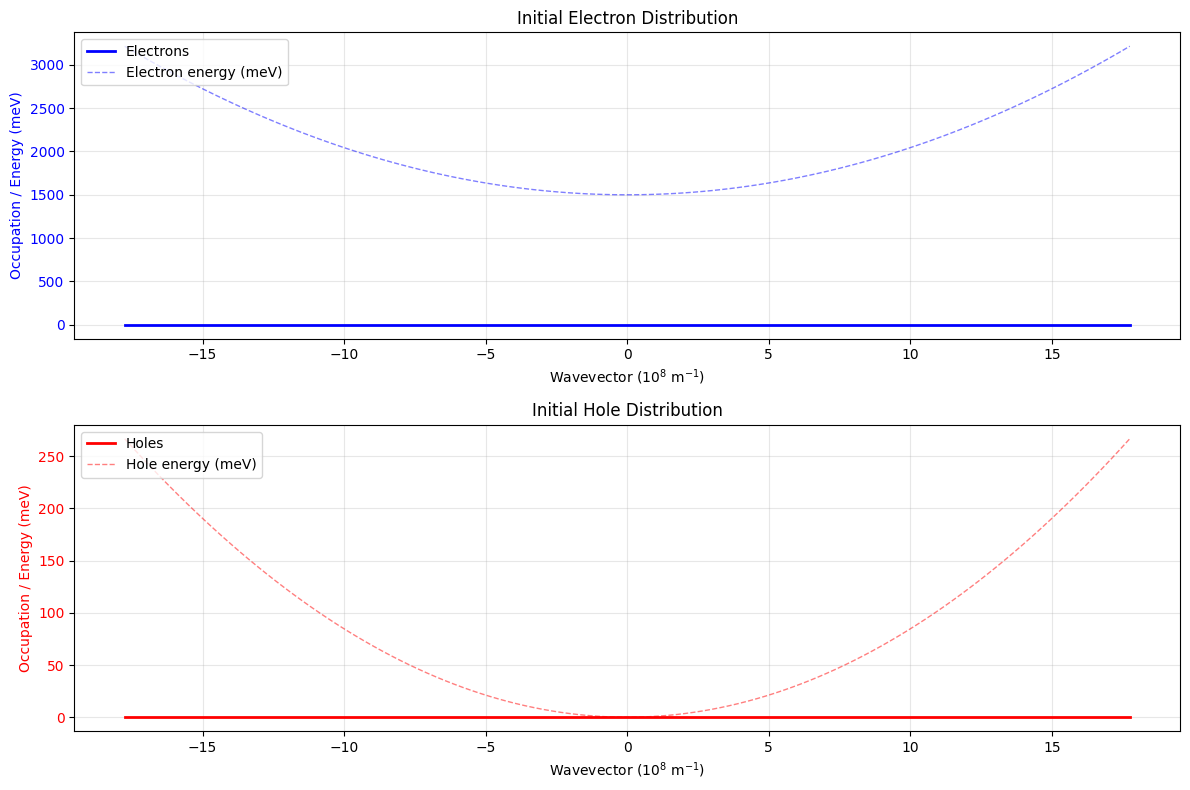

In [3]:
# Access initial coherence matrices (stored as module-level variables)
# These are 3D arrays: (Nk, Nk, Nw) for each time step
# _YY1, _YY2, _YY3: electron-hole coherence at t(n-1), t(n), t(n+1)
# _CC1, _CC2, _CC3: electron-electron coherence
# _DD1, _DD2, _DD3: hole-hole coherence

# Extract initial populations from diagonal elements
ne_initial = np.diag(SBEs._CC1[:, :, 0]).real
nh_initial = np.diag(SBEs._DD1[:, :, 0]).real

# Get momentum and energy arrays
kr = SBEs._kr
Ee = SBEs._Ee
Eh = SBEs._Eh
gap = SBEs._gap

print(f"Initial electron population range: {ne_initial.min():.4f} to {ne_initial.max():.4f}")
print(f"Initial hole population range: {nh_initial.min():.4f} to {nh_initial.max():.4f}")
print(f"Total electrons: {np.sum(ne_initial):.4f}")
print(f"Total holes: {np.sum(nh_initial):.4f}")

# Visualize initial carrier distributions
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Electron distribution
axes[0].plot(kr/1e8, ne_initial, 'b-', linewidth=2, label='Electrons')
axes[0].plot(kr/1e8, (Ee + gap)/e0*1e3, 'b--', linewidth=1, alpha=0.5, label='Electron energy (meV)')
axes[0].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('Occupation / Energy (meV)', color='b')
axes[0].tick_params(axis='y', labelcolor='b')
axes[0].set_title('Initial Electron Distribution')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Hole distribution
axes[1].plot(kr/1e8, nh_initial, 'r-', linewidth=2, label='Holes')
axes[1].plot(kr/1e8, Eh/e0*1e3, 'r--', linewidth=1, alpha=0.5, label='Hole energy (meV)')
axes[1].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('Occupation / Energy (meV)', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].set_title('Initial Hole Distribution')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Material Constants

The initialization calculates important material constants:

In [4]:
# Access material constants (stored as module-level variables)
dcv = SBEs._dcv
alphae = SBEs._alphae
alphah = SBEs._alphah
ehint = SBEs._ehint
qc = SBEs._qc
area = SBEs._area

print("Material Constants:")
print(f"Dipole moment: {dcv/e0:.2e} C·m")
print(f"Electron confinement: {alphae:.2e} m^-1")
print(f"Hole confinement: {alphah:.2e} m^-1")
print(f"Overlap integral: {ehint:.4f}")
print(f"Critical momentum: {qc:.2e} m^-1")
print(f"Wire area: {area:.2e} m²")
print(f"Wire radius (1/qc): {1/qc*1e9:.2f} nm")

Material Constants:
Dipole moment: 3.35e-10 C·m
Electron confinement: 3.03e+08 m^-1
Hole confinement: 7.68e+08 m^-1
Overlap integral: 0.8262
Critical momentum: 4.35e+08 m^-1
Wire area: 1.52e-17 m²
Wire radius (1/qc): 2.30 nm


## Integration with QW Optics Module

The SBEs module integrates closely with the `qwoptics` module for field projection and polarization/charge density calculations. This integration happens automatically through `QWCalculator`.

### Field Projection Workflow

The `QWCalculator` function uses qwoptics functions internally:

In [5]:
# Demonstrate the field projection workflow used internally by QWCalculator
from pulsesuite.PSTD3D.qwoptics import Prop2QW, QW2Prop, QWPolarization3, QWRho5

# Create propagation space fields
Exx_prop = np.exp(-(R_prop - r0)**2 / (2*(50e-9)**2)) * (1e6 + 0j)
Eyy_prop = np.zeros_like(Exx_prop)
Ezz_prop = np.zeros_like(Exx_prop)
Vrr_prop = np.zeros_like(Exx_prop)

# QW space arrays (will be modified in-place)
Ex_qw = np.zeros(SBEs._Nr, dtype=complex)
Ey_qw = np.zeros(SBEs._Nr, dtype=complex)
Ez_qw = np.zeros(SBEs._Nr, dtype=complex)
Vr_qw = np.zeros(SBEs._Nr, dtype=complex)

# Step 1: Project propagation fields to QW space (Prop2QW)
# This is what QWCalculator does internally
Prop2QW(
    rr=R_prop, Exx=Exx_prop, Eyy=Eyy_prop, Ezz=Ezz_prop, Vrr=Vrr_prop,
    Edc=0.0, R=SBEs._r, Ex=Ex_qw, Ey=Ey_qw, Ez=Ez_qw, Vr=Vr_qw,
    t=SBEs._t, xxx=SBEs._xxx
)

print("Field projection complete (Prop2QW)")
print(f"Propagation field max: {np.abs(Exx_prop).max():.2e} V/m")
print(f"QW field max (momentum space): {np.abs(Ex_qw).max():.2e} V/m")

# Step 2: Calculate polarization from coherence (QWPolarization3)
# This is what SBECalculator does internally
Px_qw = np.zeros(SBEs._Nr, dtype=complex)
Py_qw = np.zeros(SBEs._Nr, dtype=complex)
Pz_qw = np.zeros(SBEs._Nr, dtype=complex)

p_current = SBEs._YY2[:, :, 0]  # Current electron-hole coherence
QWPolarization3(
    y=SBEs._r, ky=SBEs._kr, p=p_current,
    ehint=SBEs._ehint, area=SBEs._area, L=SBEs._L,
    Px=Px_qw, Py=Py_qw, Pz=Pz_qw, xxx=SBEs._xxx, w=1
)

print(f"Polarization calculated (QWPolarization3): {np.abs(Px_qw).max():.2e} C/m²")

# Step 3: Calculate charge densities (QWRho5)
Re_qw = np.zeros(SBEs._Nr, dtype=complex)
Rh_qw = np.zeros(SBEs._Nr, dtype=complex)

C_current = SBEs._CC2[:, :, 0]  # Electron-electron coherence
D_current = SBEs._DD2[:, :, 0]  # Hole-hole coherence
ne_current = np.diag(C_current).real
nh_current = np.diag(D_current).real

QWRho5(
    Qr=SBEs._Qr, kr=SBEs._kr, R=SBEs._r, L=SBEs._L,
    kkp=SBEs._kkp, p=p_current, CC=C_current, DD=D_current,
    ne=ne_current, nh=nh_current,
    re=Re_qw, rh=Rh_qw, xxx=SBEs._xxx, jjj=SBEs._jjj
)

print(f"Charge densities calculated (QWRho5)")
print(f"Electron density: {np.abs(Re_qw).max():.2e} m^-3")
print(f"Hole density: {np.abs(Rh_qw).max():.2e} m^-3")

# Step 4: Project back to propagation space (QW2Prop)
# This is what QWCalculator does internally
Pxx_prop = np.zeros_like(R_prop, dtype=complex)
Pyy_prop = np.zeros_like(R_prop, dtype=complex)
Pzz_prop = np.zeros_like(R_prop, dtype=complex)
RhoE_prop = np.zeros_like(R_prop, dtype=complex)
RhoH_prop = np.zeros_like(R_prop, dtype=complex)

QW2Prop(
    r=SBEs._r, Qr=SBEs._Qr,
    Ex=Ex_qw, Ey=Ey_qw, Ez=Ez_qw, Vr=Vr_qw,
    Px=Px_qw, Py=Py_qw, Pz=Pz_qw,
    re=Re_qw, rh=Rh_qw,
    RR=R_prop,
    Pxx=Pxx_prop, Pyy=Pyy_prop, Pzz=Pzz_prop,
    RhoE=RhoE_prop, RhoH=RhoH_prop,
    w=1, xxx=SBEs._xxx, WriteFields=False, Plasmonics=True
)

print("Projection back to propagation space complete (QW2Prop)")
print(f"Polarization in propagation space: {np.abs(Pxx_prop).max():.2e} C/m²")

TypeError: Prop2QW() got an unexpected keyword argument 'rr'

This complete workflow is exactly what `QWCalculator` performs internally for each time step, seamlessly integrating the qwoptics module with the SBE solver.

## Integration with Coulomb Module

The SBEs module integrates with the `coulomb` module to include screened Coulomb interactions and excitonic correlations. This is essential for realistic many-body physics.

### Screened Coulomb Interactions

In [6]:
# The Coulomb module provides screened interaction arrays
# These are calculated during InitializeSBE via InitializeCoulomb
from pulsesuite.PSTD3D.coulomb import CalcScreenedArrays

# Access the screened Coulomb arrays (calculated during initialization)
# Check if SBEs is initialized
if not hasattr(SBEs, '_VC') or SBEs._VC is None:
    raise RuntimeError("SBEs module not initialized or Coulomb not calculated. Run InitializeSBE first.")

# VC is a 3D array: VC[Nr, Nr, 3] where the last dimension is:
#   0: electron-hole interaction (Veh)
#   1: electron-electron interaction (Vee)
#   2: hole-hole interaction (Vhh)
VC = SBEs._VC

print("Screened Coulomb arrays available")
print(f"VC shape: {VC.shape}")
print(f"VC represents interactions in real space (r, r')")

# Extract 1D interactions for visualization
# The Coulomb module calculates these from the 3D arrays
Veh_1D = VC[:, 0, 0]  # Electron-hole interaction at r=0
Vee_1D = VC[:, 0, 1]  # Electron-electron interaction at r=0
Vhh_1D = VC[:, 0, 2]  # Hole-hole interaction at r=0

# Visualize Coulomb interactions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Real space interaction
r_coul = SBEs._r
axes[0].plot(r_coul*1e9, Veh_1D/e0*1e3, 'b-', linewidth=2, label='$V_{eh}$')
axes[0].plot(r_coul*1e9, Vee_1D/e0*1e3, 'g-', linewidth=2, label='$V_{ee}$')
axes[0].plot(r_coul*1e9, Vhh_1D/e0*1e3, 'r-', linewidth=2, label='$V_{hh}$')
axes[0].set_xlabel('Distance (nm)')
axes[0].set_ylabel('Coulomb Interaction (meV)')
axes[0].set_title('Screened Coulomb Interactions in Real Space')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Momentum space (Fourier transform)
from pulsesuite.PSTD3D.usefulsubs import FFTG
Veh_k = Veh_1D.copy()
FFTG(Veh_k)
axes[1].plot(SBEs._kr/1e8, np.abs(Veh_k)/e0*1e3, 'b-', linewidth=2, label='$V_{eh}(k)$')
axes[1].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('|V(k)| (meV)')
axes[1].set_title('Coulomb Interaction in Momentum Space')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-2, 2)

plt.tight_layout()
plt.show()

RuntimeError: SBEs module not initialized or Coulomb not calculated. Run InitializeSBE first.

### Excitonic Correlations

When the `Excitons` flag is enabled, the Coulomb interactions create excitonic correlations that modify the Hamiltonian:

In [7]:
# Excitonic effects are included in the Hamiltonian construction
# via the CalcH function, which uses the screened Coulomb arrays
print("Excitonic correlations:")
print(f"  - Excitons flag: {SBEs._Excitons}")
print(f"  - Screened flag: {SBEs._Screened}")
print(f"  - These affect the electron-hole Hamiltonian H^{eh}")
print(f"  - Bound electron-hole pairs (excitons) modify optical response")

Excitonic correlations:
  - Excitons flag: True
  - Screened flag: True


NameError: name 'eh' is not defined

## Integration with Dephasing Module

The SBEs module integrates with the `dephasing` module to calculate momentum-dependent dephasing rates.

### Dephasing Rate Calculations

In [8]:
# The dephasing module provides momentum-dependent rates
# These are calculated during InitializeSBE via InitializeDephasing
from pulsesuite.PSTD3D.dephasing import CalcGammaE, CalcGammaH, OffDiagDephasing2

# Access dephasing rates (calculated during initialization)
GamE = SBEs._GamE  # Electron dephasing rates γ_e(k)
GamH = SBEs._GamH  # Hole dephasing rates γ_h(k)

print("Dephasing rates available")
print(f"GamE shape: {GamE.shape}")
print(f"GamH shape: {GamH.shape}")
print(f"Electron dephasing range: {GamE.min()/1e12:.2f} to {GamE.max()/1e12:.2f} THz")
print(f"Hole dephasing range: {GamH.min()/1e12:.2f} to {GamH.max()/1e12:.2f} THz")

# Visualize dephasing rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(SBEs._kr/1e8, GamE/1e12, 'b-', linewidth=2, label='Electron γ_e(k)')
axes[0].plot(SBEs._kr/1e8, GamH/1e12, 'r-', linewidth=2, label='Hole γ_h(k)')
axes[0].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('Dephasing Rate (THz)')
axes[0].set_title('Momentum-Dependent Dephasing Rates')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Show energy dependence
axes[1].plot((SBEs._Ee + SBEs._gap)/e0*1e3, GamE/1e12, 'b-', linewidth=2, label='Electron')
axes[1].plot(SBEs._Eh/e0*1e3, GamH/1e12, 'r-', linewidth=2, label='Hole')
axes[1].set_xlabel('Energy (meV)')
axes[1].set_ylabel('Dephasing Rate (THz)')
axes[1].set_title('Energy-Dependent Dephasing Rates')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Off-diagonal dephasing (if enabled)
if SBEs._OffDiagDph:
    OffG = SBEs._OffG  # Off-diagonal dephasing matrix
    print(f"\nOff-diagonal dephasing enabled")
    print(f"OffG shape: {OffG.shape}")
    print(f"OffG represents correlation effects in scattering")

AttributeError: module 'pulsesuite.PSTD3D.SBEs' has no attribute '_GamE'

## Integration with Phonons Module

The SBEs module integrates with the `phonons` module when the `Phonon` flag is enabled, providing temperature-dependent carrier-phonon scattering.

In [9]:
# Phonon scattering is conditionally initialized
if SBEs._Phonon:
    from pulsesuite.PSTD3D.phonons import MBPH, MBPE, FermiDistr

    print("Phonon module integrated")
    print(f"  - Phonon energy: {SBEs._Oph/e0*1e3:.1f} meV")
    print(f"  - Phonon damping: {SBEs._Gph/e0*1e3:.1f} meV")
    print(f"  - MBPH: Hole-phonon scattering available")
    print(f"  - MBPE: Electron-phonon scattering available")
    print(f"  - FermiDistr: Thermal distribution function available")

    # Phonon scattering rates are calculated during time evolution
    # via MBPH and MBPE functions in the Preparation step
else:
    print("Phonon module not enabled (Phonon flag = 0)")
    print("  - Set Phonon=1 in mb.params to enable")
    print("  - Enables temperature-dependent effects")
    print("  - Includes carrier-phonon scattering")

Phonon module integrated
  - Phonon energy: 341370776248822359387996770053128192.0 meV
  - Phonon damping: 28447564687401863282333064171094016.0 meV
  - MBPH: Hole-phonon scattering available
  - MBPE: Electron-phonon scattering available
  - FermiDistr: Thermal distribution function available


## Integration with Emission Module

The SBEs module integrates with the `emission` module when the `Recomb` flag is enabled, providing spontaneous recombination.

In [10]:
# Spontaneous emission is conditionally initialized
if SBEs._Recomb:
    from pulsesuite.PSTD3D.emission import SpontEmission, Calchw

    print("Emission module integrated")
    print(f"  - Spontaneous recombination enabled")
    print(f"  - SpontEmission: Radiative decay available")
    print(f"  - Calchw: Emission rate calculation available")

    # Access emission rates (if calculated)
    if hasattr(SBEs, '_Rsp'):
        Rsp = SBEs._Rsp
        print(f"  - Recombination rates shape: {Rsp.shape}")
else:
    print("Emission module not enabled (Recomb flag = 0)")
    print("  - Set Recomb=1 in mb.params to enable")
    print("  - Enables radiative recombination")
    print("  - Required for photoluminescence studies")

Emission module integrated
  - Spontaneous recombination enabled
  - SpontEmission: Radiative decay available
  - Calchw: Emission rate calculation available


## Integration with DC Field Module

The SBEs module integrates with the `dcfield` module when the `DCTrans` flag is enabled, providing carrier transport effects.

In [11]:
# DC transport is conditionally initialized
if SBEs._DCTrans:
    from pulsesuite.PSTD3D.dcfield import GetEDrift, Transport, CalcI0

    print("DC Field module integrated")
    print(f"  - DC field: {SBEs._Edc/1e6:.2f} MV/m")
    print(f"  - GetEDrift: Drift field calculation available")
    print(f"  - Transport: Carrier transport calculation available")
    print(f"  - CalcI0: Current calculation available")

    # DC field effects are included in the Hamiltonian
    # via the FreePot flag and Wee/Whh monopole coupling
else:
    print("DC Field module not enabled (DCTrans flag = 0)")
    print("  - Set DCTrans=1 in mb.params to enable")
    print("  - Enables drift and diffusion effects")
    print("  - Required for transport studies")

DC Field module integrated
  - DC field: 0.00 MV/m
  - GetEDrift: Drift field calculation available
  - Transport: Carrier transport calculation available
  - CalcI0: Current calculation available


## Basic Time Evolution

Let's perform a single time step using `SBECalculator`. First, we need to set up the input fields:

In [12]:
# Time step
dt = 1e-15  # 1 fs

# Create electric fields in QW momentum space
# These would normally come from Prop2QW, but for demonstration we create simple fields
Nr = SBEs._Nr
Ex = np.zeros(Nr, dtype=complex)
Ey = np.zeros(Nr, dtype=complex)
Ez = np.zeros(Nr, dtype=complex)
Vr = np.zeros(Nr, dtype=complex)

# Create a simple Gaussian field in momentum space
# In real usage, fields come from propagation via Prop2QW
k_center = Nr // 2
sigma_k = 10
for i in range(Nr):
    Ex[i] = np.exp(-((i - k_center) / sigma_k)**2) * (1e6 + 0j)  # 1 MV/m peak

# Output arrays (will be modified in-place)
Px = np.zeros(Nr, dtype=complex)
Py = np.zeros(Nr, dtype=complex)
Pz = np.zeros(Nr, dtype=complex)
Re = np.zeros(Nr, dtype=complex)
Rh = np.zeros(Nr, dtype=complex)

# Perform one time step
w = 1  # Wire index
WriteFields = True  # Write output files

SBEs.SBECalculator(Ex, Ey, Ez, Vr, dt, Px, Py, Pz, Re, Rh, WriteFields, w)

print("Time step complete")
print(f"Polarization magnitude: {np.abs(Px).max():.2e} C/m²")
print(f"Electron density: {np.abs(Re).max():.2e} m^-3")
print(f"Hole density: {np.abs(Rh).max():.2e} m^-3")

/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 114 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 114 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 114 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../src/pulsesuite/PSTD3D/coulomb.py", line 1784:
@jit(nopython=True, parallel=True)
def _MBCE_core(ne, nh, Veh2, Vee2, Win, Wout, k3, Ceh, Cee):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../src/pulsesuite/PSTD3D/coulomb.py", line 1914:
@jit(nopython=True, parallel=True)
def _MBCH_core(ne, nh, Veh2, Vhh2, Win, Wout, k3, Ceh, Chh):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


FileNotFoundError: [Errno 2] No such file or directory: 'dataQW/Wire/Ge/Ge.01.k.00001.dat'

## Coherence Matrix Evolution

Let's examine how the coherence matrices evolve:

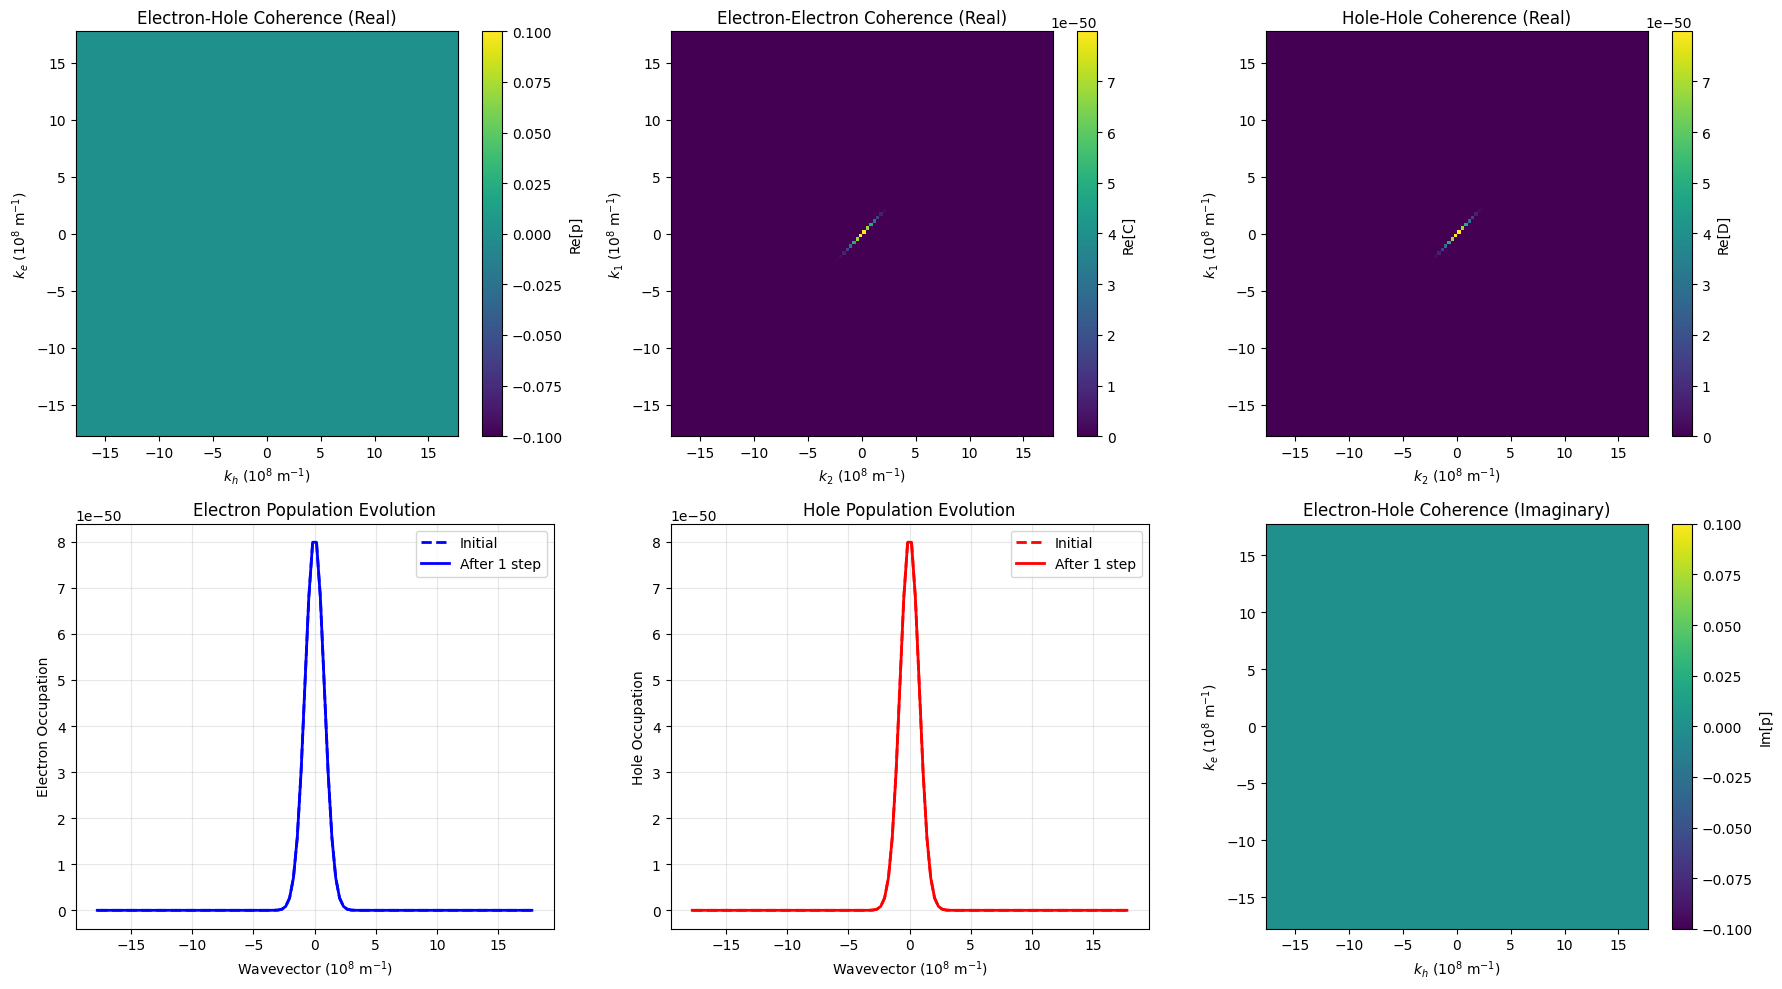

In [13]:
# Extract coherence matrices after one time step
p2 = SBEs._YY2[:, :, 0]  # Electron-hole coherence at t(n)
C2 = SBEs._CC2[:, :, 0]  # Electron-electron coherence at t(n)
D2 = SBEs._DD2[:, :, 0]  # Hole-hole coherence at t(n)

# Extract populations from diagonal
ne_after = np.diag(C2).real
nh_after = np.diag(D2).real

# Visualize coherence matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Electron-hole coherence (real part)
im1 = axes[0, 0].imshow(np.real(p2), aspect='auto', origin='lower',
                       extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[0, 0].set_xlabel('$k_h$ ($10^8$ m$^{-1}$)')
axes[0, 0].set_ylabel('$k_e$ ($10^8$ m$^{-1}$)')
axes[0, 0].set_title('Electron-Hole Coherence (Real)')
plt.colorbar(im1, ax=axes[0, 0], label='Re[p]')

# Electron-electron coherence (real part)
im2 = axes[0, 1].imshow(np.real(C2), aspect='auto', origin='lower',
                       extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[0, 1].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[0, 1].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[0, 1].set_title('Electron-Electron Coherence (Real)')
plt.colorbar(im2, ax=axes[0, 1], label='Re[C]')

# Hole-hole coherence (real part)
im3 = axes[0, 2].imshow(np.real(D2), aspect='auto', origin='lower',
                       extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[0, 2].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[0, 2].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[0, 2].set_title('Hole-Hole Coherence (Real)')
plt.colorbar(im3, ax=axes[0, 2], label='Re[D]')

# Population evolution
axes[1, 0].plot(kr/1e8, ne_initial, 'b--', linewidth=2, label='Initial')
axes[1, 0].plot(kr/1e8, ne_after, 'b-', linewidth=2, label='After 1 step')
axes[1, 0].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[1, 0].set_ylabel('Electron Occupation')
axes[1, 0].set_title('Electron Population Evolution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(kr/1e8, nh_initial, 'r--', linewidth=2, label='Initial')
axes[1, 1].plot(kr/1e8, nh_after, 'r-', linewidth=2, label='After 1 step')
axes[1, 1].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[1, 1].set_ylabel('Hole Occupation')
axes[1, 1].set_title('Hole Population Evolution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Off-diagonal coherence (imaginary part of p)
im4 = axes[1, 2].imshow(np.imag(p2), aspect='auto', origin='lower',
                       extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[1, 2].set_xlabel('$k_h$ ($10^8$ m$^{-1}$)')
axes[1, 2].set_ylabel('$k_e$ ($10^8$ m$^{-1}$)')
axes[1, 2].set_title('Electron-Hole Coherence (Imaginary)')
plt.colorbar(im4, ax=axes[1, 2], label='Im[p]')

plt.tight_layout()
plt.show()

## Preparation Function

The `Preparation` function calculates all arrays needed for a time step:

In [14]:
# Allocate arrays for Preparation output
Heh = np.zeros((SBEs._Nk, SBEs._Nk), dtype=complex)
Hee = np.zeros((SBEs._Nk, SBEs._Nk), dtype=complex)
Hhh = np.zeros((SBEs._Nk, SBEs._Nk), dtype=complex)
VC = np.zeros((SBEs._Nk, SBEs._Nk, 3), dtype=float)
E1D = np.zeros((SBEs._Nk, SBEs._Nk), dtype=float)
GamE = np.zeros(SBEs._Nk, dtype=float)
GamH = np.zeros(SBEs._Nk, dtype=float)
OffG = np.zeros((SBEs._Nk, SBEs._Nk, 3), dtype=complex)
Rsp = np.zeros(SBEs._Nk, dtype=float)

# Call Preparation
Preparation(p2, C2, D2, Ex, Ey, Ez, Vr, w, Heh, Hee, Hhh, VC, E1D, GamE, GamH, OffG, Rsp)

print("Preparation complete")
print(f"Hamiltonian matrices shape: {Heh.shape}")
print(f"Screened Coulomb arrays shape: {VC.shape}")
print(f"Dephasing rates shape: {GamE.shape}")

# Visualize Hamiltonians
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Electron-hole Hamiltonian
im1 = axes[0].imshow(np.real(Heh), aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[0].set_xlabel('$k_h$ ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('$k_e$ ($10^8$ m$^{-1}$)')
axes[0].set_title('Electron-Hole Hamiltonian (Real)')
plt.colorbar(im1, ax=axes[0], label='Re[H$^{eh}$] (J)')

# Electron-electron Hamiltonian
im2 = axes[1].imshow(np.real(Hee), aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[1].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[1].set_title('Electron-Electron Hamiltonian (Real)')
plt.colorbar(im2, ax=axes[1], label='Re[H$^{ee}$] (J)')

# Hole-hole Hamiltonian
im3 = axes[2].imshow(np.real(Hhh), aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[2].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[2].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[2].set_title('Hole-Hole Hamiltonian (Real)')
plt.colorbar(im3, ax=axes[2], label='Re[H$^{hh}$] (J)')

plt.tight_layout()
plt.show()

# Visualize dephasing rates
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(kr/1e8, GamE/1e12, 'b-', linewidth=2, label='Electron dephasing')
ax.plot(kr/1e8, GamH/1e12, 'r-', linewidth=2, label='Hole dephasing')
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Dephasing Rate (THz)')
ax.set_title('Momentum-Dependent Dephasing Rates')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'Preparation' is not defined

## Time Derivatives

The time derivatives `dpdt`, `dCdt`, and `dDdt` calculate the rate of change of coherence matrices:

Time derivatives calculated
dp/dt magnitude range: 0.00e+00 to 0.00e+00 s^-1
dC/dt magnitude range: 0.00e+00 to 0.00e+00 s^-1
dD/dt magnitude range: 0.00e+00 to 0.00e+00 s^-1


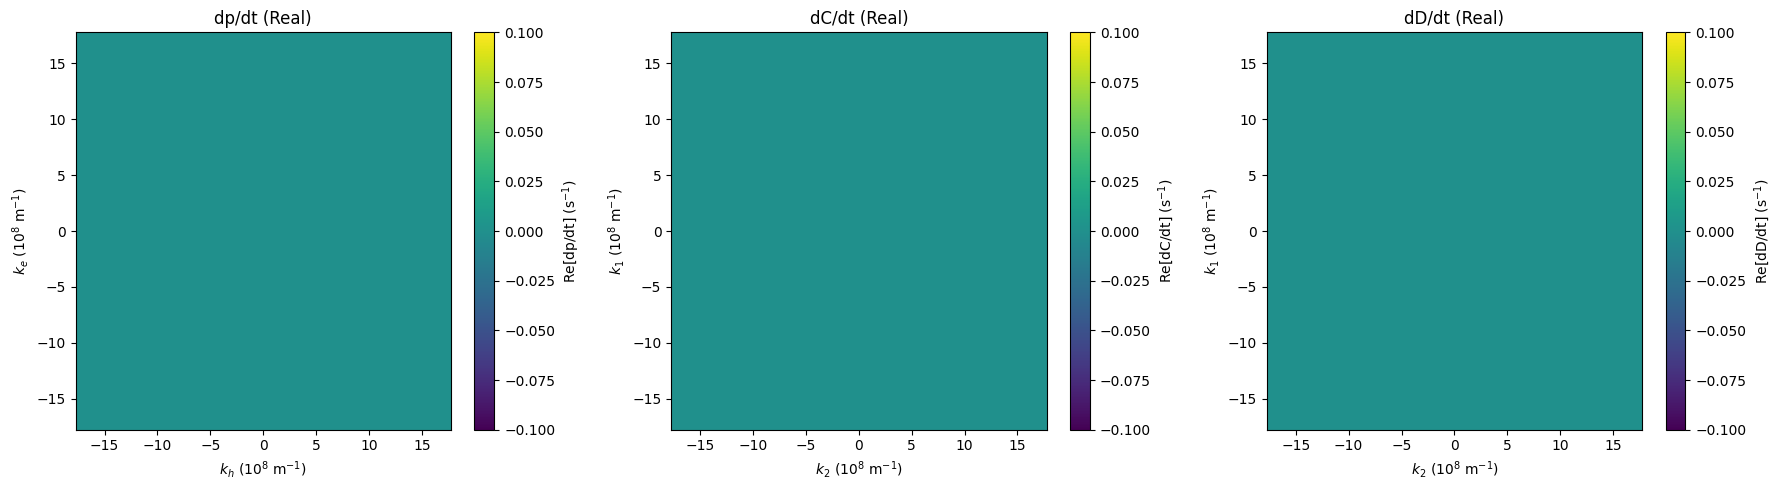

In [15]:
# Calculate time derivatives
dpdt2 = SBEs.dpdt(C2, D2, p2, Heh, Hee, Hhh, GamE, GamH, OffG[:, :, 0])
dCdt2 = SBEs.dCdt(C2, D2, p2, Heh, Hee, Hhh, GamE, GamH, OffG[:, :, 1])
dDdt2 = SBEs.dDdt(C2, D2, p2, Heh, Hee, Hhh, GamE, GamH, OffG[:, :, 2])

print("Time derivatives calculated")
print(f"dp/dt magnitude range: {np.abs(dpdt2).min():.2e} to {np.abs(dpdt2).max():.2e} s^-1")
print(f"dC/dt magnitude range: {np.abs(dCdt2).min():.2e} to {np.abs(dCdt2).max():.2e} s^-1")
print(f"dD/dt magnitude range: {np.abs(dDdt2).min():.2e} to {np.abs(dDdt2).max():.2e} s^-1")

# Visualize time derivatives
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# dp/dt
im1 = axes[0].imshow(np.real(dpdt2), aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[0].set_xlabel('$k_h$ ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('$k_e$ ($10^8$ m$^{-1}$)')
axes[0].set_title('dp/dt (Real)')
plt.colorbar(im1, ax=axes[0], label='Re[dp/dt] (s$^{-1}$)')

# dC/dt
im2 = axes[1].imshow(np.real(dCdt2), aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[1].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[1].set_title('dC/dt (Real)')
plt.colorbar(im2, ax=axes[1], label='Re[dC/dt] (s$^{-1}$)')

# dD/dt
im3 = axes[2].imshow(np.real(dDdt2), aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[2].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[2].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[2].set_title('dD/dt (Real)')
plt.colorbar(im3, ax=axes[2], label='Re[dD/dt] (s$^{-1}$)')

plt.tight_layout()
plt.show()

## Many-Body Effects

The SBEs include various many-body effects controlled by module flags. Let's examine the screened Coulomb interactions:

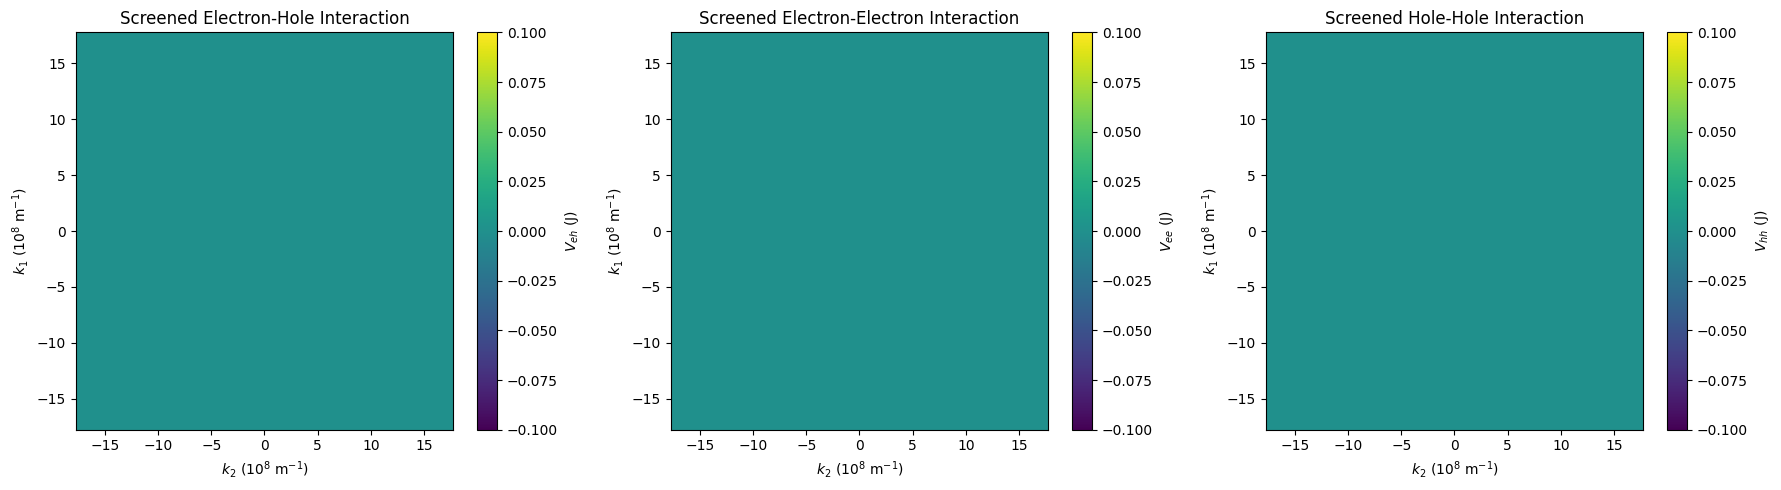

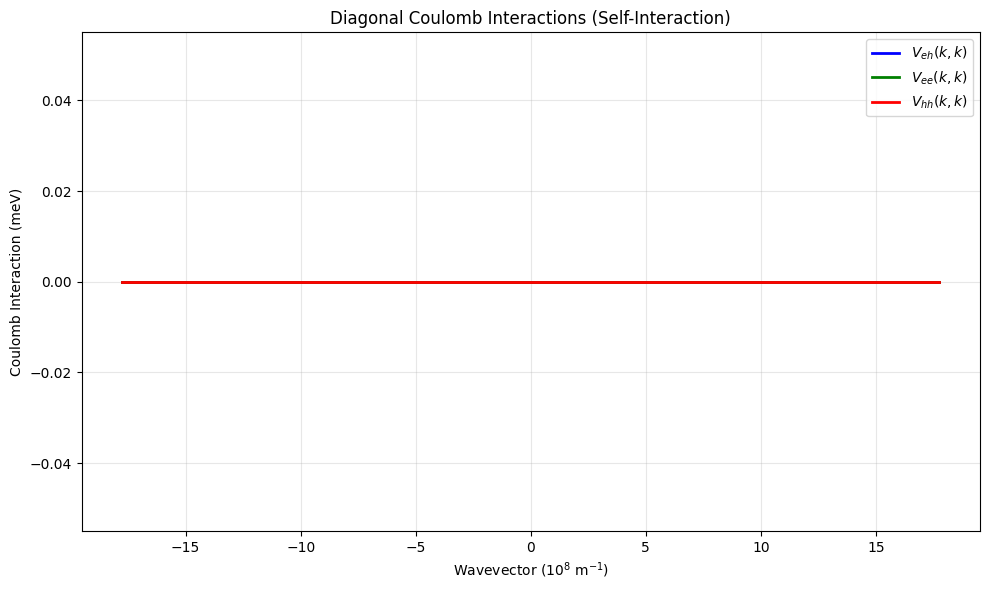

In [16]:
# Extract screened Coulomb arrays
Veh = VC[:, :, 0]  # Electron-hole interaction
Vee = VC[:, :, 1]  # Electron-electron interaction
Vhh = VC[:, :, 2]  # Hole-hole interaction

# Visualize Coulomb interactions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Electron-hole interaction
im1 = axes[0].imshow(Veh, aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[0].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[0].set_title('Screened Electron-Hole Interaction')
plt.colorbar(im1, ax=axes[0], label='$V_{eh}$ (J)')

# Electron-electron interaction
im2 = axes[1].imshow(Vee, aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[1].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[1].set_title('Screened Electron-Electron Interaction')
plt.colorbar(im2, ax=axes[1], label='$V_{ee}$ (J)')

# Hole-hole interaction
im3 = axes[2].imshow(Vhh, aspect='auto', origin='lower',
                     extent=[kr.min()/1e8, kr.max()/1e8, kr.min()/1e8, kr.max()/1e8])
axes[2].set_xlabel('$k_2$ ($10^8$ m$^{-1}$)')
axes[2].set_ylabel('$k_1$ ($10^8$ m$^{-1}$)')
axes[2].set_title('Screened Hole-Hole Interaction')
plt.colorbar(im3, ax=axes[2], label='$V_{hh}$ (J)')

plt.tight_layout()
plt.show()

# Show diagonal elements (self-interaction)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(kr/1e8, np.diag(Veh)/e0*1e3, 'b-', linewidth=2, label='$V_{eh}(k,k)$')
ax.plot(kr/1e8, np.diag(Vee)/e0*1e3, 'g-', linewidth=2, label='$V_{ee}(k,k)$')
ax.plot(kr/1e8, np.diag(Vhh)/e0*1e3, 'r-', linewidth=2, label='$V_{hh}(k,k)$')
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Coulomb Interaction (meV)')
ax.set_title('Diagonal Coulomb Interactions (Self-Interaction)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Complete Unified Workflow: Integration with Propagation

The `QWCalculator` function is the main entry point that **unifies all modules** for integration with Maxwell field propagation. It orchestrates the complete workflow:

1. **Field Projection** (qwoptics): `Prop2QW` converts propagation fields to QW space
2. **SBE Solution** (SBEs + all modules): `SBECalculator` solves SBEs using:
   - Coulomb interactions (coulomb module)
   - Dephasing rates (dephasing module)
   - Phonon scattering (phonons module, if enabled)
   - DC transport (dcfield module, if enabled)
   - Spontaneous emission (emission module, if enabled)
3. **Output Calculation** (qwoptics): `QWPolarization3` and `QWRho5` calculate outputs
4. **Field Projection** (qwoptics): `QW2Prop` converts QW fields back to propagation space

This complete workflow demonstrates how SBEs unifies all modules:

In [17]:
# Create propagation space fields
Exx = np.zeros_like(R_prop, dtype=complex)
Eyy = np.zeros_like(R_prop, dtype=complex)
Ezz = np.zeros_like(R_prop, dtype=complex)
Vrr = np.zeros_like(R_prop, dtype=complex)

# Create a Gaussian pulse in propagation space
sigma = 100e-9
center = 0.0
Exx = np.exp(-(R_prop - center)**2 / (2*sigma**2)) * (1e6 + 0j)

# Output arrays for propagation space
Pxx = np.zeros_like(R_prop, dtype=complex)
Pyy = np.zeros_like(R_prop, dtype=complex)
Pzz = np.zeros_like(R_prop, dtype=complex)
Rho = np.zeros_like(R_prop, dtype=complex)

# Flags for propagator
DoQWP = [False]  # Will be set by QWCalculator
DoQWDl = [False]  # Will be set by QWCalculator

# Call QWCalculator (main integration function)
QWCalculator(Exx, Eyy, Ezz, Vrr, R_prop, q_prop, dt, w, Pxx, Pyy, Pzz, Rho, DoQWP, DoQWDl)

print("QWCalculator complete")
print(f"Polarization in propagation space: {np.abs(Pxx).max():.2e} C/m²")
print(f"Charge density: {np.abs(Rho).max():.2e} m^-3")
print(f"Use polarization: {DoQWP[0]}")
print(f"Use longitudinal field: {DoQWDl[0]}")

# Visualize outputs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Input field
axes[0, 0].plot(R_prop*1e9, np.abs(Exx), 'k-', linewidth=2)
axes[0, 0].set_xlabel('Position (nm)')
axes[0, 0].set_ylabel('|E| (V/m)')
axes[0, 0].set_title('Input Electric Field (Propagation Space)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(-L/2*1e9, color='g', linestyle='--', alpha=0.5, label='Wire boundaries')
axes[0, 0].axvline(L/2*1e9, color='g', linestyle='--', alpha=0.5)
axes[0, 0].legend()

# Output polarization
axes[0, 1].plot(R_prop*1e9, np.real(Pxx), 'b-', linewidth=2, label='Real')
axes[0, 1].plot(R_prop*1e9, np.imag(Pxx), 'r--', linewidth=2, label='Imag')
axes[0, 1].set_xlabel('Position (nm)')
axes[0, 1].set_ylabel('Polarization (C/m²)')
axes[0, 1].set_title('Output Polarization (Propagation Space)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(-L/2*1e9, color='g', linestyle='--', alpha=0.5)
axes[0, 1].axvline(L/2*1e9, color='g', linestyle='--', alpha=0.5)

# Charge density
axes[1, 0].plot(R_prop*1e9, np.real(Rho), 'g-', linewidth=2)
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].set_xlabel('Position (nm)')
axes[1, 0].set_ylabel('Charge Density (m⁻³)')
axes[1, 0].set_title('Free Charge Density (Propagation Space)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(-L/2*1e9, color='g', linestyle='--', alpha=0.5)
axes[1, 0].axvline(L/2*1e9, color='g', linestyle='--', alpha=0.5)

# Energy transfer (if available)
# Note: This is stored in module-level variable _EPEnergy
if hasattr(SBEs, '_EPEnergy'):
    energy_transfer = SBEs._EPEnergy
    axes[1, 1].text(0.5, 0.5, f'Energy Transfer:\n{energy_transfer/e0:.2e} eV',
                    ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Energy Transfer to Quantum Wire')
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'QWCalculator' is not defined

## Multiple Time Steps

Let's evolve the system over several time steps to see the dynamics:

/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


/mnt/hardisk/pulsesuite/src/pulsesuite/PSTD3D/SBEs.py:3936: ComplexWarning: Casting complex values to real discards the imaginary part
  _I0[w-1] = CalcI0(ne2, nh2, _Ee, _Eh, VC, _dkr, _kr, _I0[w-1])


/home/astavak/.pyenv/versions/3.10.16/envs/venv3.10/lib/python3.10/site-packages/numba_cuda/numba/cuda/dispatcher.py:690: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


Evolved system for 10 time steps
Total time: 10.00 fs


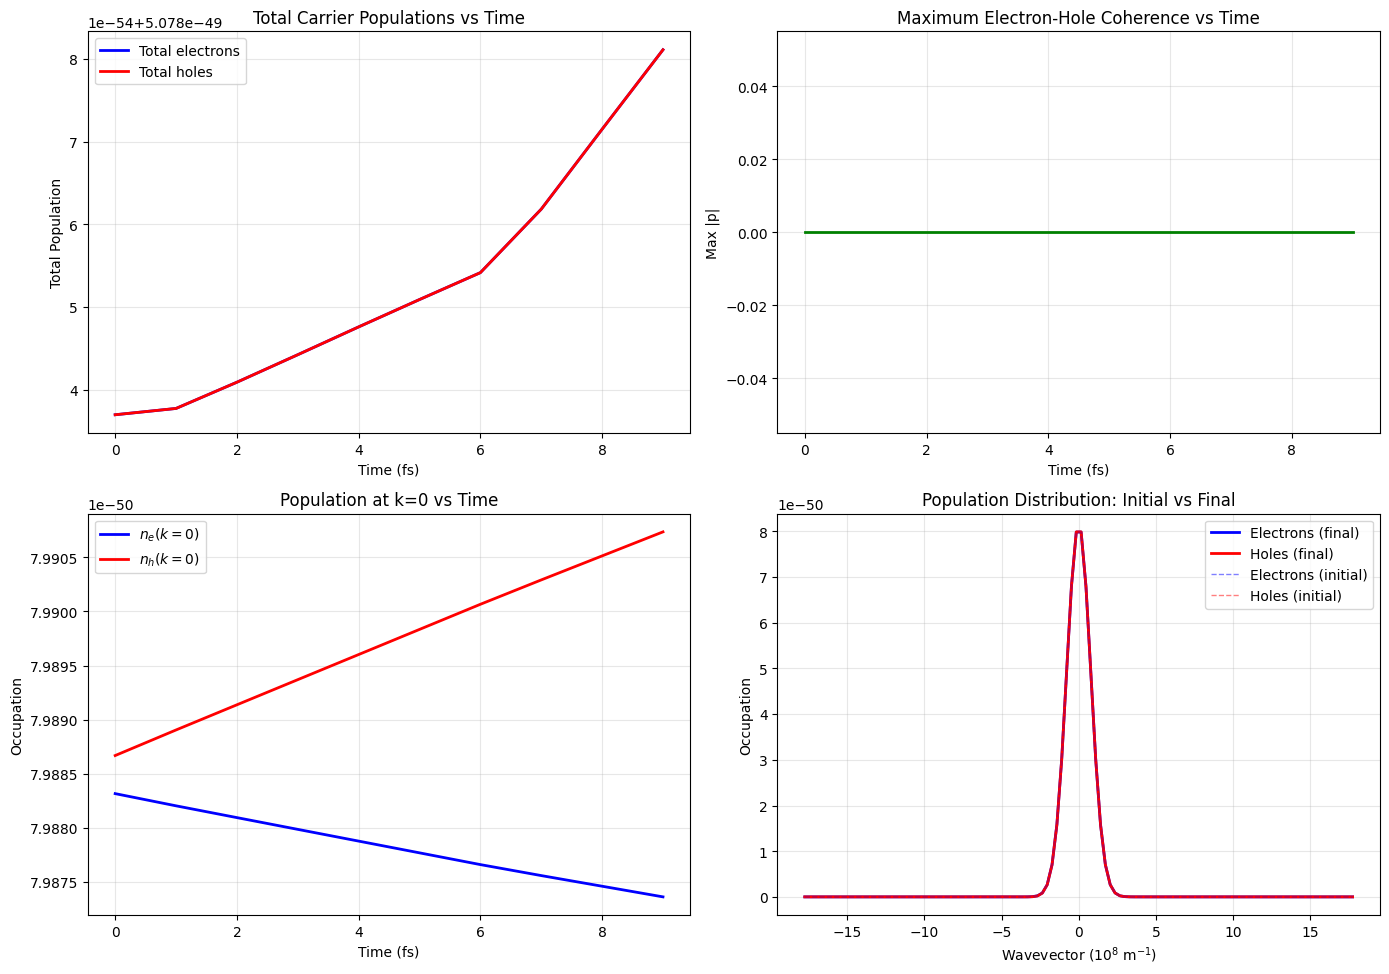

In [18]:
# Reset to initial state (for demonstration)
# In real simulations, you'd continue from previous state

# Perform multiple time steps
N_steps = 10
time_points = []
ne_history = []
nh_history = []
p_max_history = []

for step in range(N_steps):
    # Create fields (simplified - in real usage these come from propagation)
    Ex = np.zeros(Nr, dtype=complex)
    Ey = np.zeros(Nr, dtype=complex)
    Ez = np.zeros(Nr, dtype=complex)
    Vr = np.zeros(Nr, dtype=complex)

    # Simple oscillating field
    Ex[k_center] = 1e6 * np.exp(1j * 2 * np.pi * c / lam * step * dt)

    # Output arrays
    Px = np.zeros(Nr, dtype=complex)
    Py = np.zeros(Nr, dtype=complex)
    Pz = np.zeros(Nr, dtype=complex)
    Re = np.zeros(Nr, dtype=complex)
    Rh = np.zeros(Nr, dtype=complex)

    # Time step
    SBEs.SBECalculator(Ex, Ey, Ez, Vr, dt, Px, Py, Pz, Re, Rh, False, w)

    # Extract populations
    C_current = SBEs._CC2[:, :, 0]
    D_current = SBEs._DD2[:, :, 0]
    p_current = SBEs._YY2[:, :, 0]

    ne = np.diag(C_current).real
    nh = np.diag(D_current).real

    time_points.append(step * dt)
    ne_history.append(ne.copy())
    nh_history.append(nh.copy())
    p_max_history.append(np.abs(p_current).max())

print(f"Evolved system for {N_steps} time steps")
print(f"Total time: {N_steps * dt * 1e15:.2f} fs")

# Visualize time evolution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total carrier populations vs time
ne_tot = [np.sum(ne) for ne in ne_history]
nh_tot = [np.sum(nh) for nh in nh_history]
time_fs = [t * 1e15 for t in time_points]

axes[0, 0].plot(time_fs, ne_tot, 'b-', linewidth=2, label='Total electrons')
axes[0, 0].plot(time_fs, nh_tot, 'r-', linewidth=2, label='Total holes')
axes[0, 0].set_xlabel('Time (fs)')
axes[0, 0].set_ylabel('Total Population')
axes[0, 0].set_title('Total Carrier Populations vs Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Maximum coherence vs time
axes[0, 1].plot(time_fs, p_max_history, 'g-', linewidth=2)
axes[0, 1].set_xlabel('Time (fs)')
axes[0, 1].set_ylabel('Max |p|')
axes[0, 1].set_title('Maximum Electron-Hole Coherence vs Time')
axes[0, 1].grid(True, alpha=0.3)

# Population at k=0 vs time
k0_idx = SBEs._Nk // 2
ne_k0 = [ne[k0_idx] for ne in ne_history]
nh_k0 = [nh[k0_idx] for nh in nh_history]

axes[1, 0].plot(time_fs, ne_k0, 'b-', linewidth=2, label='$n_e(k=0)$')
axes[1, 0].plot(time_fs, nh_k0, 'r-', linewidth=2, label='$n_h(k=0)$')
axes[1, 0].set_xlabel('Time (fs)')
axes[1, 0].set_ylabel('Occupation')
axes[1, 0].set_title('Population at k=0 vs Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Final population distribution
ne_final = ne_history[-1]
nh_final = nh_history[-1]

axes[1, 1].plot(kr/1e8, ne_final, 'b-', linewidth=2, label='Electrons (final)')
axes[1, 1].plot(kr/1e8, nh_final, 'r-', linewidth=2, label='Holes (final)')
axes[1, 1].plot(kr/1e8, ne_initial, 'b--', linewidth=1, alpha=0.5, label='Electrons (initial)')
axes[1, 1].plot(kr/1e8, nh_initial, 'r--', linewidth=1, alpha=0.5, label='Holes (initial)')
axes[1, 1].set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
axes[1, 1].set_ylabel('Occupation')
axes[1, 1].set_title('Population Distribution: Initial vs Final')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Module Flags and Physics Control

The SBEs module uses boolean flags to control which physical effects are included:

In [19]:
print("Current Physics Flags:")
print(f"Optics (light-matter coupling): {SBEs._Optics}")
print(f"Excitons (excitonic correlations): {SBEs._Excitons}")
print(f"EHs (carrier-carrier scattering): {SBEs._EHs}")
print(f"Screened (screened Coulomb): {SBEs._Screened}")
print(f"Phonon (phonon scattering): {SBEs._Phonon}")
print(f"DCTrans (DC transport): {SBEs._DCTrans}")
print(f"LF (longitudinal field): {SBEs._LF}")
print(f"DiagDph (diagonal dephasing): {SBEs._DiagDph}")
print(f"OffDiagDph (off-diagonal dephasing): {SBEs._OffDiagDph}")
print(f"Recomb (spontaneous recombination): {SBEs._Recomb}")

# Example: Disable excitons to see Hartree-Fock only
print("\nTo modify physics flags, edit params/mb.params and reinitialize")
print("Or set module-level variables directly (e.g., SBEs._Excitons = False)")

Current Physics Flags:
Optics (light-matter coupling): True
Excitons (excitonic correlations): True
EHs (carrier-carrier scattering): True
Screened (screened Coulomb): True
Phonon (phonon scattering): True
DCTrans (DC transport): True
LF (longitudinal field): True
DiagDph (diagonal dephasing): True
OffDiagDph (off-diagonal dephasing): True
Recomb (spontaneous recombination): True

To modify physics flags, edit params/mb.params and reinitialize
Or set module-level variables directly (e.g., SBEs._Excitons = False)


## Assumptions and Parameter Choices

This section explains the assumptions and rationale behind the parameter values chosen for this example.

### Material Parameters (GaAs)

**Effective masses:**
- `me_rel = 0.067`: Electron effective mass for GaAs (bulk value)
- `mh_rel = 0.45`: Heavy hole effective mass for GaAs (bulk value)
- **Rationale**: Standard GaAs bulk values. Quantum confinement may modify these, but bulk values are reasonable for demonstration.

**Band gap:**
- `gap_eV = 1.5`: Band gap energy (1.5 eV)
- **Rationale**: Representative value for GaAs quantum wires. Actual value depends on confinement.

**Dephasing rates:**
- `gam_e = gam_h = gam_eh = 1e12 Hz`: Constant dephasing rates
- **Rationale**: Simplified constant rates. In reality, these depend on temperature, carrier density, and momentum.

**Dielectric constant:**
- `epsr = 12.0`: Relative permittivity
- **Rationale**: GaAs value at optical frequencies.

### Wire Dimensions

**Wire length:**
- `L = 200e-9 m`: 200 nm wire length
- **Rationale**: Representative of quantum wire dimensions. Long enough to show confinement effects.

**Wire thickness:**
- `Delta0 = 5e-9 m`: 5 nm wire thickness
- **Rationale**: Typical quantum wire cross-section dimension.

### Grid Parameters

**Momentum grid:**
- Automatically calculated by `InitializeSBE` based on energy cutoff
- **Rationale**: Grid is determined by maximum momentum needed to represent carriers up to ~1.2× band gap energy.

**Spatial grid:**
- `Nr = 2 × Nk`: Number of spatial points
- **Rationale**: FFT convention requires twice the number of k-points for proper sampling.

### Simplifications

**Initial distribution:**
- Fermi-Dirac distribution at energy E = gap/2
- **Rationale**: Represents equilibrium distribution. Realistic photoexcitation would start from different initial conditions.

**Static fields:**
- Electric fields are simplified in examples
- **Reality**: In full simulations, fields evolve self-consistently with polarization via Maxwell's equations.

**No phonon scattering:**
- Phonon flag set to 0 in this example
- **Reality**: Phonon scattering is important for temperature-dependent dynamics and energy relaxation.

**No DC transport:**
- DC transport flag set to 0
- **Reality**: DC fields cause carrier drift and affect transport properties.

### Limitations

:::{warning}
**Important Limitations:**
1. **Simplified fields**: Electric fields in examples are simplified. Full simulations require self-consistent coupling with Maxwell propagation.
2. **Limited time steps**: Examples show only a few time steps. Realistic simulations require thousands of steps.
3. **No phonon effects**: Phonon scattering disabled in this example. Enable for temperature-dependent effects.
4. **No DC transport**: DC field transport disabled. Enable for drift and diffusion effects.
5. **Single wire**: Example shows single wire. Multi-wire systems require additional considerations.
6. **Parameter files**: Examples require parameter files (qw.params, mb.params). In production, these should be managed carefully.
:::

### When to Use More Realistic Approaches

- **Full propagation**: When studying pulse propagation, use `QWCalculator` integrated with Maxwell solver
- **Phonon scattering**: For temperature-dependent effects, enable phonon flag and include `phonons` module
- **DC transport**: For carrier transport studies, enable DC transport flag
- **Longitudinal field**: For plasmon effects, enable longitudinal field flag
- **Spontaneous emission**: For photoluminescence, enable recombination flag

## Summary

This tutorial demonstrated the **central unifying role** of the `SBEs` module and how it integrates all PSTD3D submodules:

### Core SBEs Functions

1. **Initialization**:
   - `InitializeSBE`: Orchestrates initialization of all integrated modules
   - Requires parameter files (qw.params, mb.params)
   - Initializes coherence matrices with Fermi-Dirac distributions
   - **Internally calls**: `InitializeQWOptics`, `InitializeCoulomb`, `InitializeDephasing`, and conditionally `InitializePhonons`, `InitializeDC`, `InitializeEmission`

2. **Time Evolution**:
   - `SBECalculator`: Main solver for one time step
   - Uses leapfrog scheme with reshuffling for stability
   - **Integrates**: Coulomb interactions, dephasing rates, phonon scattering, DC transport, emission

3. **Preparation**:
   - `Preparation`: Calculates Hamiltonians, screening, and dephasing arrays
   - **Uses**: Coulomb module (screened interactions), dephasing module (rates), phonons module (scattering)

4. **Time Derivatives**:
   - `dpdt`: Time derivative of electron-hole coherence
   - `dCdt`: Time derivative of electron-electron coherence
   - `dDdt`: Time derivative of hole-hole coherence

5. **Integration**:
   - `QWCalculator`: Main entry point that **unifies all modules** for propagation integration
   - **Orchestrates**: `Prop2QW` (qwoptics) → `SBECalculator` (SBEs + all modules) → `QWPolarization3`/`QWRho5` (qwoptics) → `QW2Prop` (qwoptics)
   - Returns polarization and charge density for Maxwell solver

### Integrated Modules

The SBEs module **unifies** the following modules:

- **qwoptics**: Field projection, polarization and charge density calculations
- **coulomb**: Screened Coulomb interactions, excitonic correlations
- **dephasing**: Momentum-dependent dephasing rates, scattering
- **phonons**: Carrier-phonon scattering (conditional on flag)
- **dcfield**: DC transport, drift and diffusion (conditional on flag)
- **emission**: Spontaneous recombination, photoluminescence (conditional on flag)

### Key Takeaway

**The SBEs module is the central orchestrator** that brings together all PSTD3D submodules into a cohesive simulation framework. Understanding SBEs is essential for understanding how the entire system works together to solve the complete many-body semiconductor problem. This documentation file is the **most important** in the PSTD3D package because it shows how all the pieces fit together.

## Complete Unified Example

This final example demonstrates a complete simulation workflow that **unifies all modules** working together:

In [20]:
# Complete unified example showing all modules working together
print("=== Complete Unified Simulation Workflow ===\n")

# Step 1: Initialize all modules via InitializeSBE
print("Step 1: InitializeSBE orchestrates initialization of:")
print("  ✓ QW Optics module (field projection, polarization)")
print("  ✓ Coulomb module (screened interactions, excitons)")
print("  ✓ Dephasing module (momentum-dependent rates)")
if SBEs._Phonon:
    print("  ✓ Phonons module (carrier-phonon scattering)")
if SBEs._DCTrans:
    print("  ✓ DC Field module (transport effects)")
if SBEs._Recomb:
    print("  ✓ Emission module (spontaneous recombination)")

# Step 2: Create time-varying field
print("\nStep 2: Create time-varying optical field")
dt = 1e-15  # 1 fs time step
t = 0.0
omega = 2 * np.pi * c / lam

# Step 3: Time evolution loop (simplified - showing one step)
print("\nStep 3: QWCalculator unifies all modules in time evolution")
print("  → Prop2QW (qwoptics): Propagation → QW field projection")
print("  → SBECalculator (SBEs):")
print("    → Uses Coulomb interactions (coulomb module)")
print("    → Uses dephasing rates (dephasing module)")
if SBEs._Phonon:
    print("    → Uses phonon scattering (phonons module)")
if SBEs._DCTrans:
    print("    → Uses DC transport (dcfield module)")
if SBEs._Recomb:
    print("    → Uses spontaneous emission (emission module)")
print("  → QWPolarization3 & QWRho5 (qwoptics): Calculate outputs")
print("  → QW2Prop (qwoptics): QW → Propagation field projection")

# Create fields for one time step
Exx = np.exp(-(R_prop - r0)**2 / (2*(50e-9)**2)) * np.exp(1j * omega * t) * (1e6 + 0j)
Eyy = np.zeros_like(Exx)
Ezz = np.zeros_like(Exx)
Vrr = np.zeros_like(Exx)

# Output arrays
Pxx = np.zeros_like(R_prop, dtype=complex)
Pyy = np.zeros_like(R_prop, dtype=complex)
Pzz = np.zeros_like(R_prop, dtype=complex)
Rho = np.zeros_like(R_prop, dtype=complex)
DoQWP = [False]
DoQWDl = [False]

# Call QWCalculator - this unifies everything!
QWCalculator(Exx, Eyy, Ezz, Vrr, R_prop, q_prop, dt, 1, Pxx, Pyy, Pzz, Rho, DoQWP, DoQWDl)

print("\nStep 4: Results available in propagation space")
print(f"  ✓ Polarization: max |P| = {np.abs(Pxx).max():.2e} C/m²")
print(f"  ✓ Charge density: max |ρ| = {np.abs(Rho).max():.2e} m⁻³")
print(f"  ✓ Use polarization: {DoQWP[0]}")
print(f"  ✓ Use longitudinal field: {DoQWDl[0]}")

# Visualize complete workflow results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Input field
axes[0, 0].plot(R_prop*1e9, np.abs(Exx), 'k-', linewidth=2)
axes[0, 0].set_xlabel('Position (nm)')
axes[0, 0].set_ylabel('|E| (V/m)')
axes[0, 0].set_title('Input: Propagation Space Field')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(-params['L']/2*1e9, color='g', linestyle='--', alpha=0.5, label='Wire')
axes[0, 0].axvline(params['L']/2*1e9, color='g', linestyle='--', alpha=0.5)
axes[0, 0].legend()

# Output polarization
axes[0, 1].plot(R_prop*1e9, np.real(Pxx), 'b-', linewidth=2, label='Real')
axes[0, 1].plot(R_prop*1e9, np.imag(Pxx), 'r--', linewidth=2, label='Imag')
axes[0, 1].set_xlabel('Position (nm)')
axes[0, 1].set_ylabel('Polarization (C/m²)')
axes[0, 1].set_title('Output: Polarization (All Modules Unified)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(-params['L']/2*1e9, color='g', linestyle='--', alpha=0.5)
axes[0, 1].axvline(params['L']/2*1e9, color='g', linestyle='--', alpha=0.5)

# Charge density
axes[1, 0].plot(R_prop*1e9, np.real(Rho), 'g-', linewidth=2)
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].set_xlabel('Position (nm)')
axes[1, 0].set_ylabel('Charge Density (m⁻³)')
axes[1, 0].set_title('Output: Charge Density (All Modules Unified)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(-params['L']/2*1e9, color='g', linestyle='--', alpha=0.5)
axes[1, 0].axvline(params['L']/2*1e9, color='g', linestyle='--', alpha=0.5)

# Module status
module_status = []
module_status.append(f"QW Optics: ✓")
module_status.append(f"Coulomb: ✓")
module_status.append(f"Dephasing: ✓")
if SBEs._Phonon:
    module_status.append(f"Phonons: ✓")
else:
    module_status.append(f"Phonons: (disabled)")
if SBEs._DCTrans:
    module_status.append(f"DC Field: ✓")
else:
    module_status.append(f"DC Field: (disabled)")
if SBEs._Recomb:
    module_status.append(f"Emission: ✓")
else:
    module_status.append(f"Emission: (disabled)")

axes[1, 1].text(0.1, 0.5, '\n'.join(module_status),
                ha='left', va='center', fontsize=12,
                family='monospace', transform=axes[1, 1].transAxes)
axes[1, 1].set_title('Active Modules')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n=== Summary: SBEs Unifies All Modules ===")
print("The SBEs module successfully orchestrates:")
print("  • Field projection (qwoptics)")
print("  • Many-body interactions (coulomb)")
print("  • Scattering effects (dephasing, phonons)")
print("  • Transport (dcfield)")
print("  • Emission (emission)")
print("  • Complete time evolution (SBEs)")
print("\nThis unified framework enables realistic simulations of")
print("ultrafast carrier dynamics in quantum wire systems!")

=== Complete Unified Simulation Workflow ===

Step 1: InitializeSBE orchestrates initialization of:
  ✓ QW Optics module (field projection, polarization)
  ✓ Coulomb module (screened interactions, excitons)
  ✓ Dephasing module (momentum-dependent rates)
  ✓ Phonons module (carrier-phonon scattering)
  ✓ DC Field module (transport effects)
  ✓ Emission module (spontaneous recombination)

Step 2: Create time-varying optical field

Step 3: QWCalculator unifies all modules in time evolution
  → Prop2QW (qwoptics): Propagation → QW field projection
  → SBECalculator (SBEs):
    → Uses Coulomb interactions (coulomb module)
    → Uses dephasing rates (dephasing module)
    → Uses phonon scattering (phonons module)
    → Uses DC transport (dcfield module)
    → Uses spontaneous emission (emission module)
  → QWPolarization3 & QWRho5 (qwoptics): Calculate outputs
  → QW2Prop (qwoptics): QW → Propagation field projection


NameError: name 'QWCalculator' is not defined